Models saved successfully!
Mean Absolute Error (MAE) for Random Forest: 558.8913797468355
Mean Absolute Error (MAE) for XGBoost: 572.3173673523378


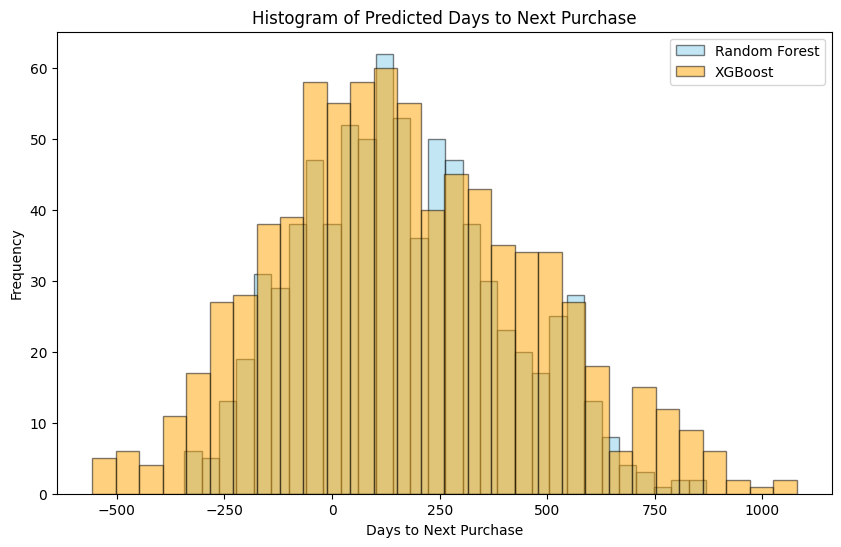

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from datetime import timedelta
import xgboost as xgb

# Load the dataset
file_path = "../data/OnlineRetail.csv"  # Ensure the file path is correct here
tx_data = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')

# Data Preprocessing
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

# Filter for UK data and ensure we avoid SettingWithCopyWarning by using .copy()
tx_uk = tx_data[tx_data['Country'] == 'United Kingdom'].copy()

# Feature Engineering
tx_max_purchase = tx_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
tx_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
tx_frequency = tx_uk.groupby('CustomerID')['InvoiceDate'].count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']

# Calculating Revenue
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_revenue.columns = ['CustomerID', 'Revenue']

# Merge the features into a single dataframe
tx_user = pd.merge(tx_max_purchase, tx_frequency, on='CustomerID', how='left')
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID', how='left')

# Define 'Recency' as days since the most recent purchase
current_date = pd.to_datetime('2024-12-07')  # Replace with today's date or dynamic date
tx_user['Recency'] = (current_date - tx_user['MaxPurchaseDate']).dt.days

# Create 'Next Purchase Day' target variable using the next purchase date (shifted value)
tx_next_purchase = tx_uk.groupby('CustomerID')['InvoiceDate'].shift(-1)  # Get next purchase date
tx_user['NextPurchaseDay'] = (tx_next_purchase - tx_user['MaxPurchaseDate']).dt.days

# Handle cases where there is no next purchase (e.g., fill with a large value like 999)
tx_user['NextPurchaseDay'] = tx_user['NextPurchaseDay'].fillna(999)

# Feature selection and target variable
features = ['Recency', 'Frequency', 'Revenue']
X = tx_user[features]

# Handle missing values in the target variable
y = tx_user['NextPurchaseDay'].fillna(999)  # Replace NaN with 999 (or another suitable value)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Save the trained models using joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
print("Models saved successfully!")

# Model evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate MAE for both models
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f'Mean Absolute Error (MAE) for Random Forest: {mae_rf}')
print(f'Mean Absolute Error (MAE) for XGBoost: {mae_xgb}')

# Optional: Plotting predicted next purchase days for better analysis
plt.figure(figsize=(10, 6))
plt.hist(y_pred_rf, bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='Random Forest')
plt.hist(y_pred_xgb, bins=30, color='orange', edgecolor='black', alpha=0.5, label='XGBoost')
plt.title('Histogram of Predicted Days to Next Purchase')
plt.xlabel('Days to Next Purchase')
plt.ylabel('Frequency')
plt.legend()
plt.show()
